In [40]:
import pandas as pd

In [56]:
# https://realpython.com/python-sockets/#tcp-sockets
# https://techtutorialsx.com/2018/05/17/esp32-arduino-sending-data-with-socket-client/

import socket

HOST = "192.168.4.102"  # Standard loopback interface address (localhost)
PORT = 8090  # Port to listen on (non-privileged ports are > 1023)

while True:

    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind((HOST, PORT))
        s.listen()
        conn, addr = s.accept()
        with conn:
            print(f"Connected by {addr}")
            while True:
                data = conn.recv(1024)
                if not data:
                    break
                print(data)
    print(" ")

Connected by ('192.168.6.172', 52416)
b'SOT, 979, 20, 57, 0, 0, 0, 15670, 99522, 62573, 9059, 395, 100, 1564, 4, EOT'
 


In [69]:
# https://realpython.com/python-sockets/#tcp-sockets
# https://techtutorialsx.com/2018/05/17/esp32-arduino-sending-data-with-socket-client/

import socket
import time

HOST = "192.168.4.102"  # Standard loopback interface address (localhost)
PORT = 8090  # Port to listen on (non-privileged ports are > 1023)

timeout = 5

df_data = None

while True:

    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind((HOST, PORT))
        s.listen()
        conn, address = s.accept()
        with conn:

            connection_start_time = time.time()

            print(f"Connected by {address}")
            while True:

                connection_time = time.time() - connection_start_time

                transmission = conn.recv(1024)
                if not transmission:
                    break
                print(transmission)
                transmission_saved = transmission
                address_saved = address

                # Break from connection if it's taking too long
                if connection_time > timeout:
                    break

    df_transmission = transmission_to_dataframe(transmission_saved, address_saved)
    if df_data is None:
        df_data = df_transmission
    else:
        df_data = pd.concat([df_data, df_transmission]) 

    if df_data.shape[0] == 100:
        break

    print(" ")

Connected by ('192.168.6.172', 51548)
b'SOT, scd_co2_ppm 1025, scd_temperature_10_degc 167, scd_humidity_10_percent 832, tsl_light_fs 0, tsl_light_ir 0, tsl_light_vis 0, bme_temperature_100_degc 15220, bme_pressure_pa 99816, bme_humidity_1000_percent 86595, bme_gas 395794, bme_iaq 100, max_level_10_percent 999, max_level_10_percent 999, max_batt_10_voltage 40, max_avg_current_ua -72343, max_temperature_100_degc 2037, EOT'
 
Connected by ('192.168.6.172', 63536)
b'SOT, scd_co2_ppm 1027, scd_temperature_10_degc 168, scd_humidity_10_percent 828, tsl_light_fs 0, tsl_light_ir 0, tsl_light_vis 0, bme_temperature_100_degc 15231, bme_pressure_pa 99787, bme_humidity_1000_percent 86348, bme_gas 349669, bme_iaq 100, max_level_10_percent 998, max_level_10_percent 998, max_batt_10_voltage 40, max_avg_current_ua -73125, max_temperature_100_degc 2050, EOT'
 
Connected by ('192.168.6.172', 58583)
b'SOT, scd_co2_ppm 1019, scd_temperature_10_degc 169, scd_humidity_10_percent 825, tsl_light_fs 0, tsl_lig

In [71]:
df_data.to_csv('./second_data.csv')

In [52]:
def transmission_to_dataframe(transmission_saved, address_saved):

    ip_address = address_saved[0]

    transmission = transmission_saved.decode('UTF-8')

    # Clean transmission:
    transmission = transmission.split(',')
    transmission = [x.lstrip(' ') for x in transmission]

    # Confirm start and end of transmission
    check1 = transmission[0] == 'SOT'
    check2 = transmission[-1] == 'EOT'
    transmission_status = True if check1 and check2 else False

    # Remove SOT and EOT
    transmission = transmission[1:-1]

    # Convert to dictionary
    keys = [x.split(' ')[0] for x in transmission]
    values = [x.split(' ')[1] for x in transmission]
    weather_data = {}
    weather_data['ip_address'] = ip_address

    for key, value in zip(keys, values):
        divisor = 1
        if '_10_' in key:
            divisor = 10
            key = key.replace('_10', '')
        elif '_100_' in key:
            divisor = 100
            key = key.replace('_100', '')
        elif '_1000_' in key:
            divisor = 1000
            key = key.replace('_1000', '')
        elif '_10000_' in key:
            divisor = 10000
            key = key.replace('_10000', '')
        weather_data[key] = [float(value) / divisor]

    df_data = pd.DataFrame.from_dict(weather_data)
    return df_data


In [70]:
df_data

,ip_address,scd_co2_ppm,scd_temperature_degc,scd_humidity_percent,tsl_light_fs,tsl_light_ir,tsl_light_vis,bme_temperature_degc,bme_pressure_pa,bme_humidity_percent,bme_gas,bme_iaq,max_level_percent,max_batt_voltage,max_avg_current_ua,max_temperature_degc
0,192.168.6.172,1025.0,16.7,83.2,0.0,0.0,0.0,152.20,99816.0,86.595,395794.0,100.0,99.9,4.0,-72343.0,20.37
0,192.168.6.172,1027.0,16.8,82.8,0.0,0.0,0.0,152.31,99787.0,86.348,349669.0,100.0,99.8,4.0,-73125.0,20.50
0,192.168.6.172,1019.0,16.9,82.5,0.0,0.0,0.0,152.43,99758.0,86.175,321610.0,100.0,99.8,4.0,-72343.0,20.62
0,192.168.6.172,1012.0,17.2,81.8,0.0,0.0,0.0,152.69,99722.0,85.612,280439.0,95.0,99.9,4.0,-76250.0,20.87
0,192.168.6.172,1009.0,17.2,81.6,0.0,0.0,0.0,152.75,99720.0,85.508,266254.0,95.0,99.9,4.0,-41250.0,20.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,192.168.6.172,1165.0,15.5,80.9,0.0,0.0,0.0,151.01,98444.0,84.815,136719.0,95.0,95.7,4.0,-64531.0,19.18
0,192.168.6.172,1175.0,15.5,80.9,0.0,0.0,0.0,150.99,98431.0,84.863,136719.0,95.0,95.7,4.0,-74218.0,19.12
0,192.168.6.172,1141.0,15.5,80.9,0.0,0.0,0.0,150.99,98431.0,84.863,136407.0,95.0,95.6,4.0,-71250.0,19.18
0,192.168.6.172,1142.0,15.5,80.9,0.0,0.0,0.0,150.99,98397.0,84.811,136511.0,95.0,95.6,4.0,-70468.0,19.18


In [62]:
import numpy as np
import matplotlib.pyplot as plt

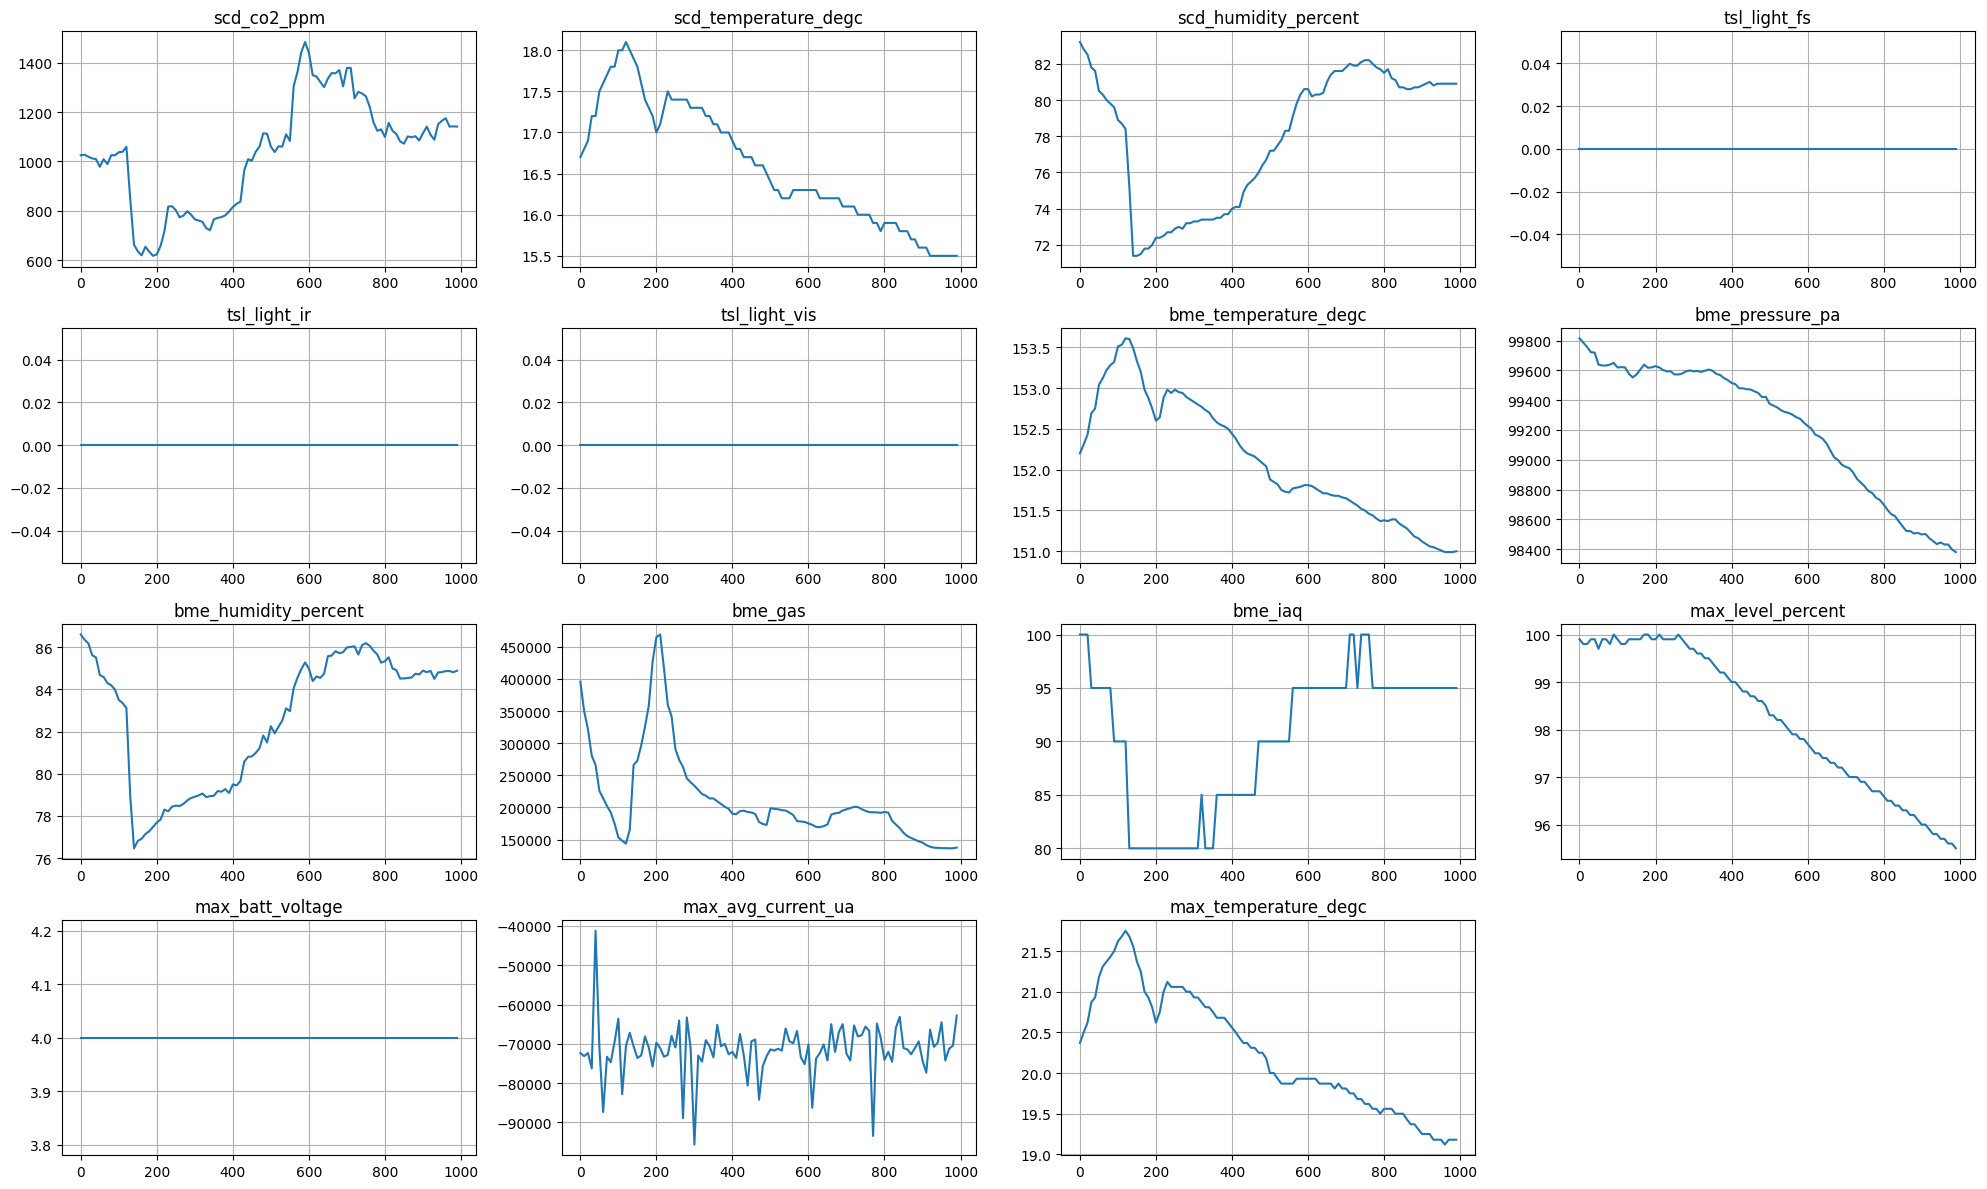

In [72]:
x = np.arange(0, 100 * 10, 10)

cols = list(df_data)

plt.figure(figsize=(20, 12))

for idx, col in enumerate(cols[1:]):

    y = df_data[col].values

    plt.subplot(4, 4, idx+1)
    plt.plot(x, y)
    plt.grid(True)
    plt.title(col)

plt.tight_layout()